## Семинар 13: Мультимодальные модели
План: рассмотреть мультимодальные архитектуры, объединяющие обработку изображений и текста:
- CLIP — совместное обучение эмбеддингов изображений и текста для zero-shot классификации;
- BLIP — генерация подписей и image-text matching (ITM);
- LLaVA — визуально-языковая модель (VLM) на базе LLM + vision encoder для VQA и рассуждений.

Все модели загружаются через библиотеку 🤗 Transformers (Hugging Face)

In [ ]:
import torch
from PIL import Image
import requests
from transformers import (
    CLIPProcessor, CLIPModel,
    BlipProcessor, BlipForConditionalGeneration,
    BlipProcessor, BlipForImageTextRetrieval,
    AutoProcessor, LlavaForConditionalGeneration,
    BitsAndBytesConfig
)
import warnings
warnings.filterwarnings("ignore")

# Опционально: установить torch precision (для ускорения на CPU/GPU без потерь)
torch.set_float32_matmul_precision('high')

In [ ]:
# Загружаем картинку
url = "https://hips.hearstapps.com/hmg-prod/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg"

try:
    response = requests.get(url, stream=True)
    response.raise_for_status()
    image = Image.open(response.raw).convert("RGB")
    print("Image loaded successfully.")
except Exception as e:
    print(f"Failed to load image: {e}")
    raise

print(image.size)

Image loaded successfully.
(1999, 1499)


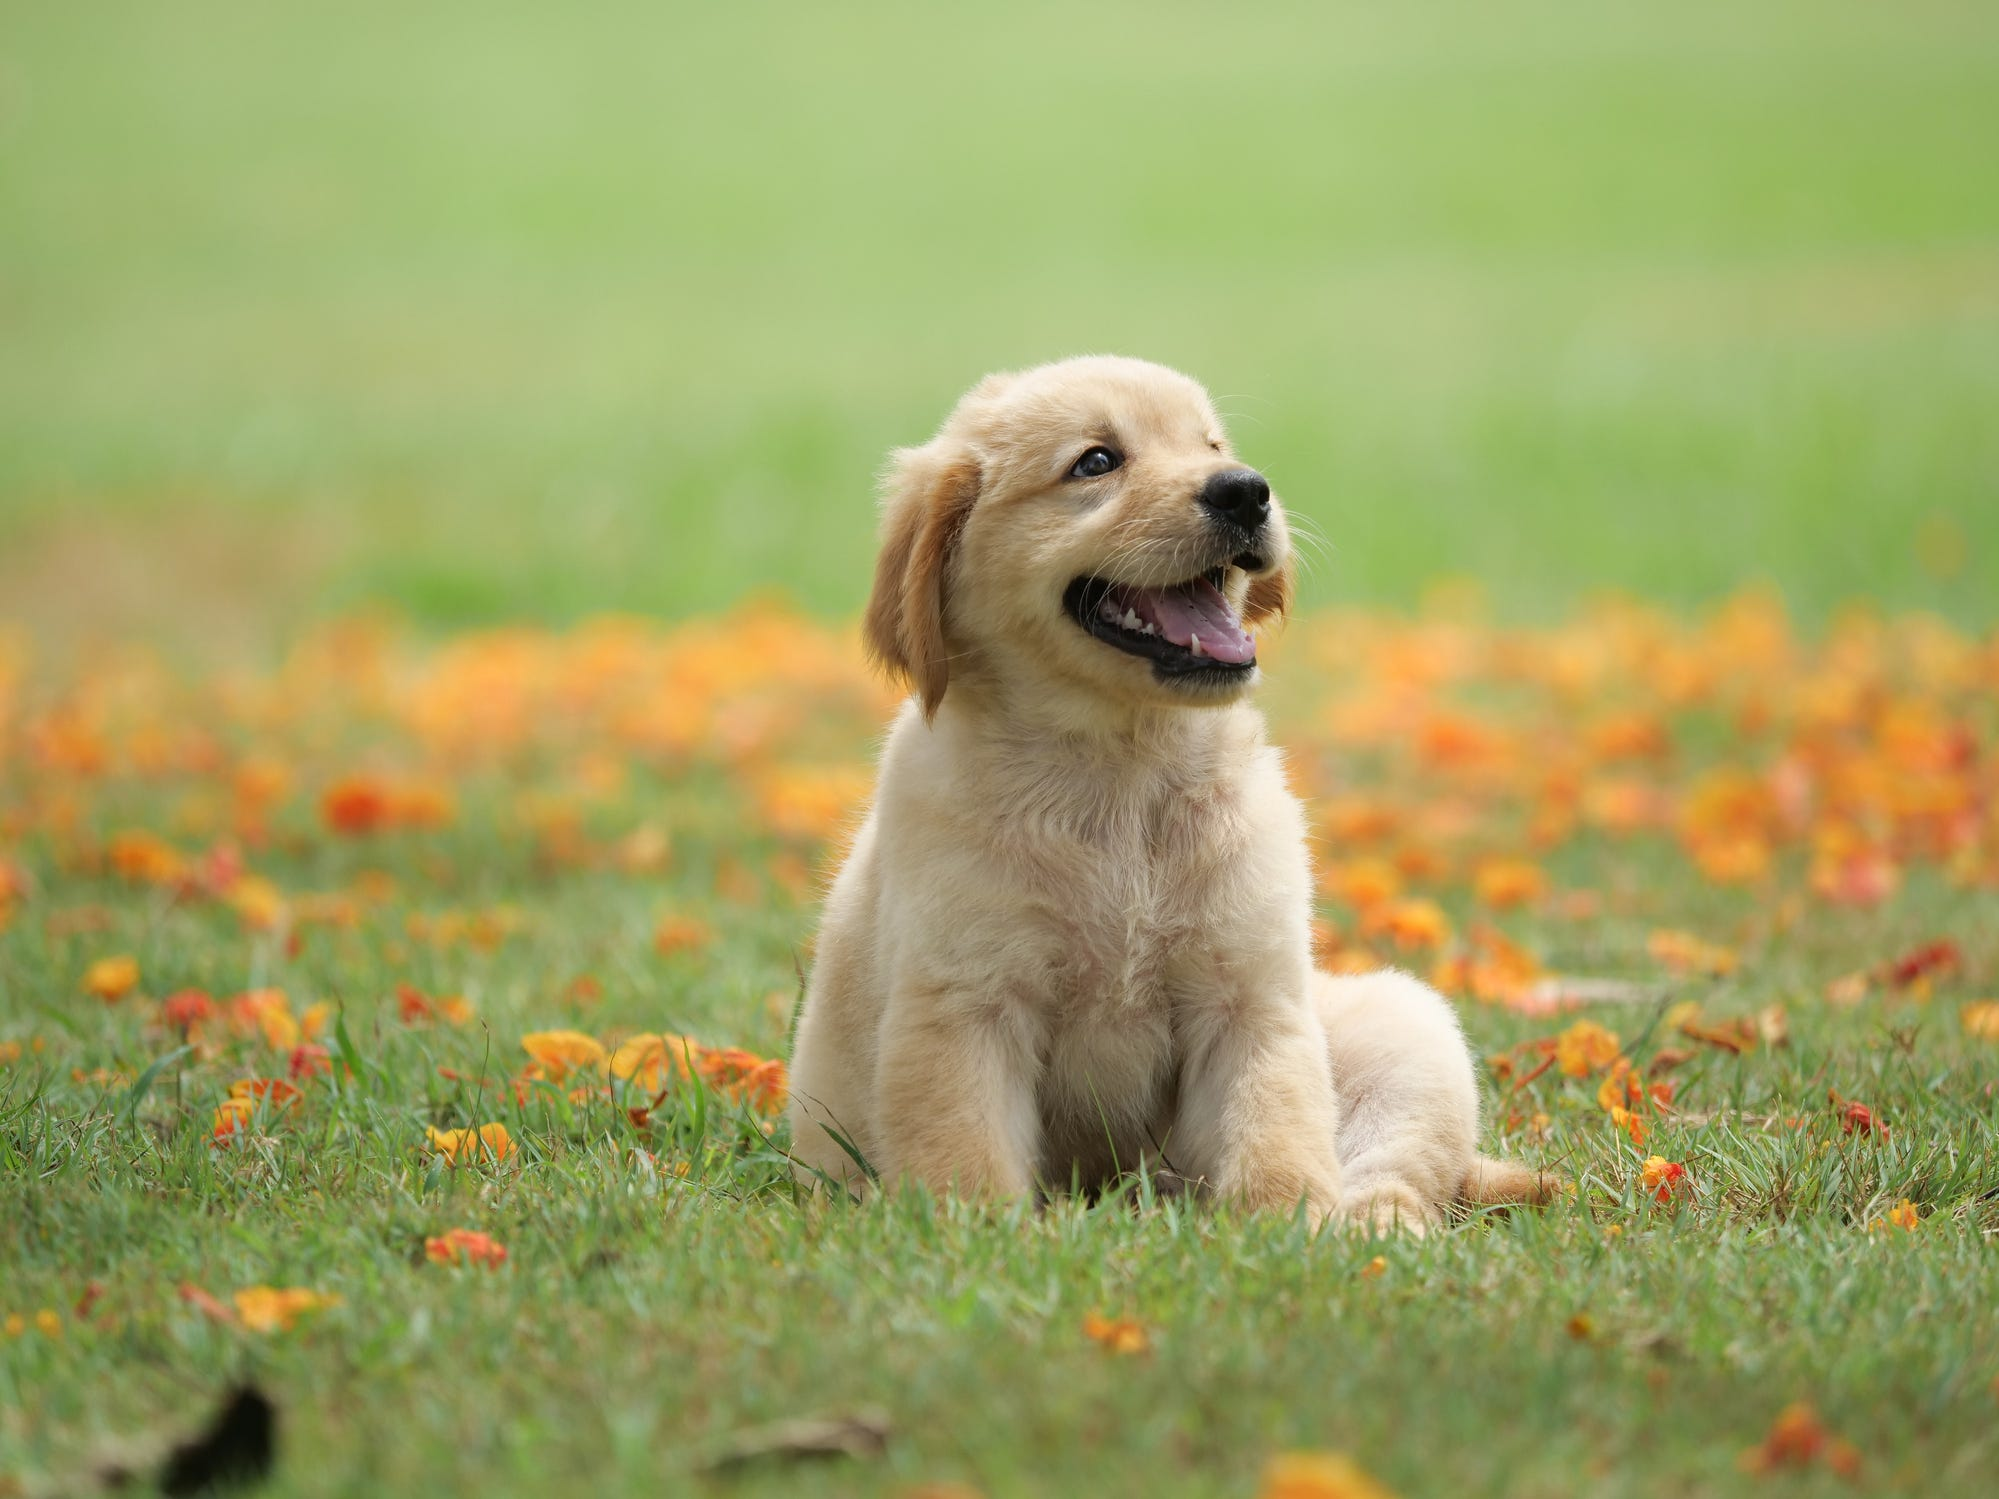

In [ ]:
image

### CLIP — zero-shot классификация

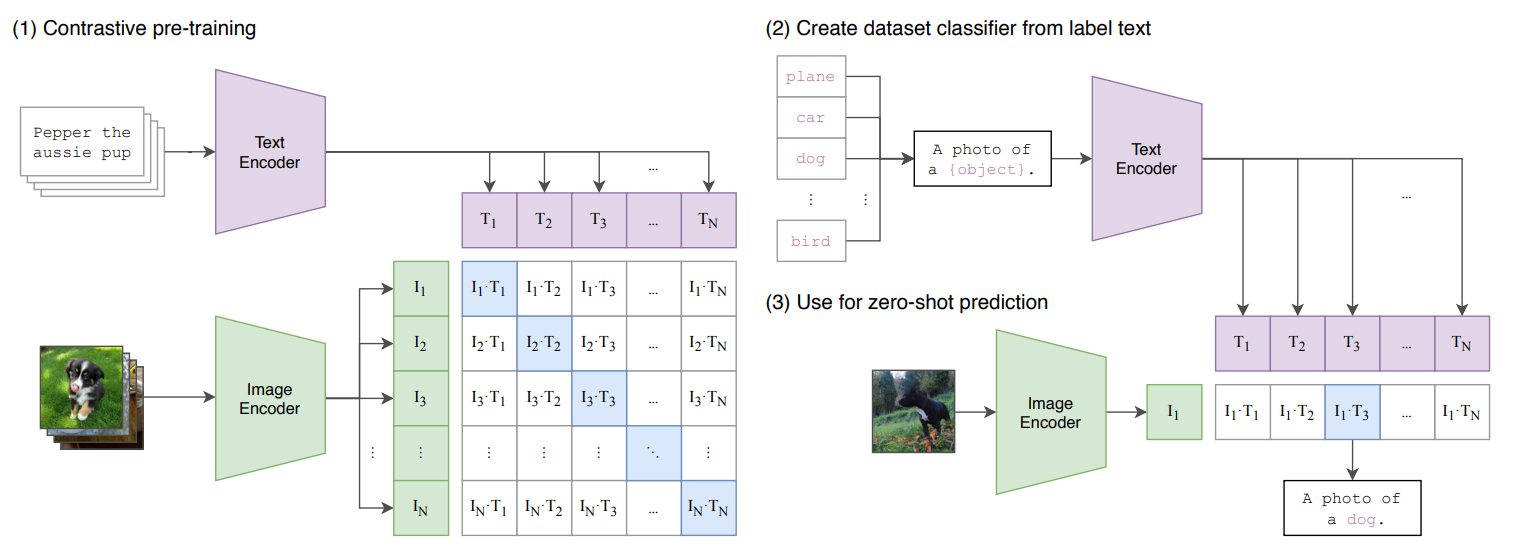

In [ ]:
print("\n[CLIP] Performing zero-shot classification...")

try:
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    clip_model.to(device)

    candidate_labels = ["a photo of a dog", "a photo of a cat", "a photo of a car", "a photo of a person"]

    inputs = clip_processor(
        text=candidate_labels,
        images=image,
        return_tensors="pt",
        padding=True
    ).to(device)

    with torch.no_grad():
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image  # shape: (1, N)
        probs = logits_per_image.softmax(dim=1).squeeze().cpu().tolist()

    print("CLIP probabilities:")
    for label, prob in zip(candidate_labels, probs):
        print(f"  {label}: {prob:.3f}")

    pred_idx = logits_per_image.argmax().item()
    print("Predicted class:", candidate_labels[pred_idx])

except Exception as e:
    print(f"[CLIP] Error: {e}")


[CLIP] Performing zero-shot classification...
CLIP probabilities:
  a photo of a dog: 0.993
  a photo of a cat: 0.001
  a photo of a car: 0.000
  a photo of a person: 0.005
Predicted class: a photo of a dog


### BLIP — image-text matching и генерация кэпшенов

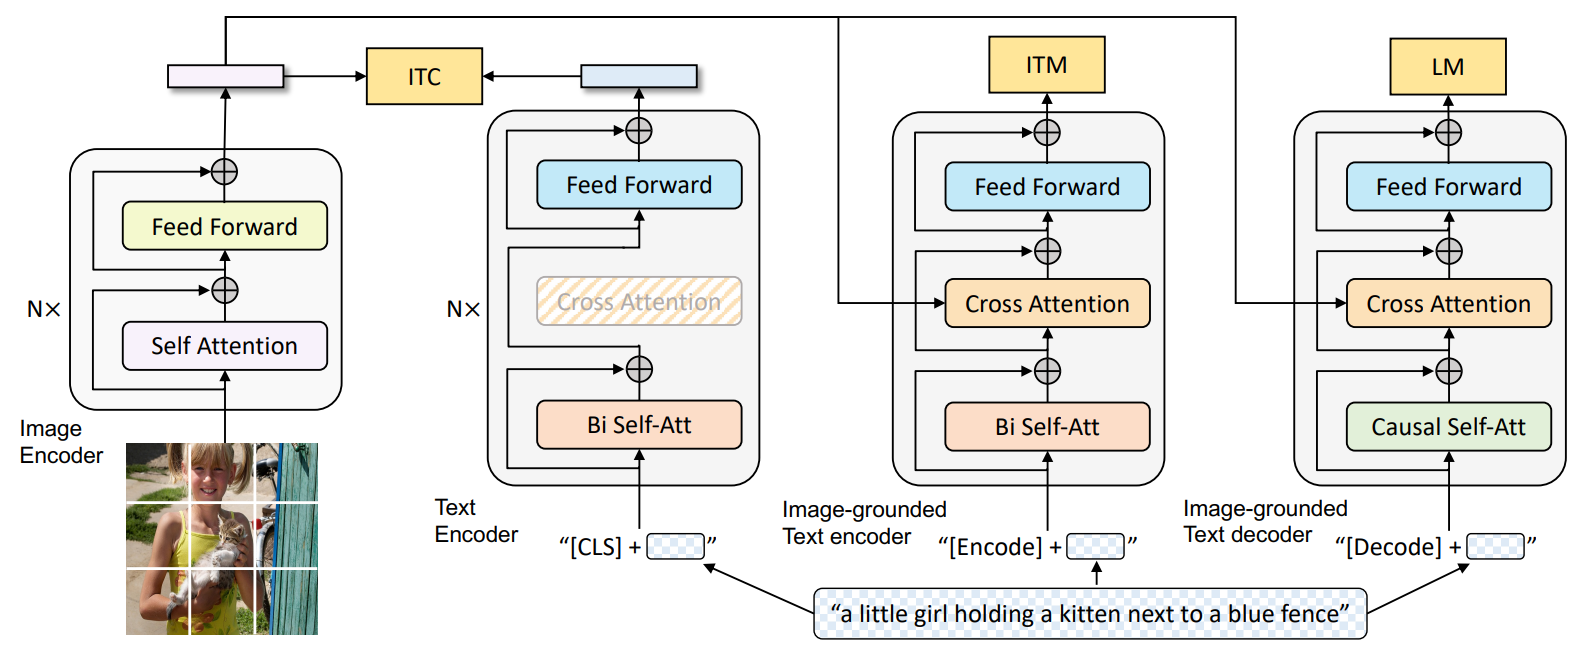

In [ ]:
print("\n[BLIP ITM] Computing image-text similarity scores...")

try:
    # Загружаем модель с ITM-головой
    blip_itm_processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-base-coco")
    blip_itm_model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-base-coco")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    blip_itm_model.to(device)

    # Список текстов для сравнения (можно поиграться и добавить свои)
    texts = [
        "a dog running in the garden",
        "a puppy sitting on grass",
        "a cat on a sofa",
        "a car parked outside",
        "a person walking a dog"
    ]

    print("Texts for matching:")
    for i, t in enumerate(texts, 1):
        print(f"  {i}. {t}")

    scores = []
    for text in texts:
        # Обработка пары (image, text)
        inputs = blip_itm_processor(
            images=image,
            text=text,
            return_tensors="pt",
            padding=True,
            truncation=True
        ).to(device)

        with torch.no_grad():
            outputs = blip_itm_model(**inputs)
            itm_score = outputs.itm_score  # shape: (1, 2)
            probs = torch.softmax(itm_score, dim=1)
            match_score = probs[0, 1].item()  # вероятность "match"
            scores.append(match_score)

    print("\nBLIP ITM similarity scores (higher = more relevant):")
    for text, score in zip(texts, scores):
        print(f"  '{text}': {score:.4f}")

    # Опционально: top-k
    top_idx = torch.tensor(scores).argmax().item()
    print(f"\nBest match: '{texts[top_idx]}' (score: {scores[top_idx]:.4f})")

except Exception as e:
    print(f"[BLIP ITM] Error: {e}")


[BLIP ITM] Computing image-text similarity scores...
Texts for matching:
  1. a dog running in the garden
  2. a puppy sitting on grass
  3. a cat on a sofa
  4. a car parked outside
  5. a person walking a dog

BLIP ITM similarity scores (higher = more relevant):
  'a dog running in the garden': 0.0002
  'a puppy sitting on grass': 0.9830
  'a cat on a sofa': 0.0000
  'a car parked outside': 0.0012
  'a person walking a dog': 0.0001

Best match: 'a puppy sitting on grass' (score: 0.9830)


In [ ]:
print("\n[BLIP] Generating caption...")

try:
    blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    blip_model.to(device)

    inputs = blip_processor(image, return_tensors="pt").to(device)

    with torch.no_grad():
        out = blip_model.generate(**inputs, max_new_tokens=20)

    caption = blip_processor.decode(out[0], skip_special_tokens=True)
    print("Caption:", caption)

except Exception as e:
    print(f"[BLIP] Error: {e}")


[BLIP] Generating caption...
Caption: a puppy sitting in the grass with its mouth open


### LLaVA — Visual Question Answering

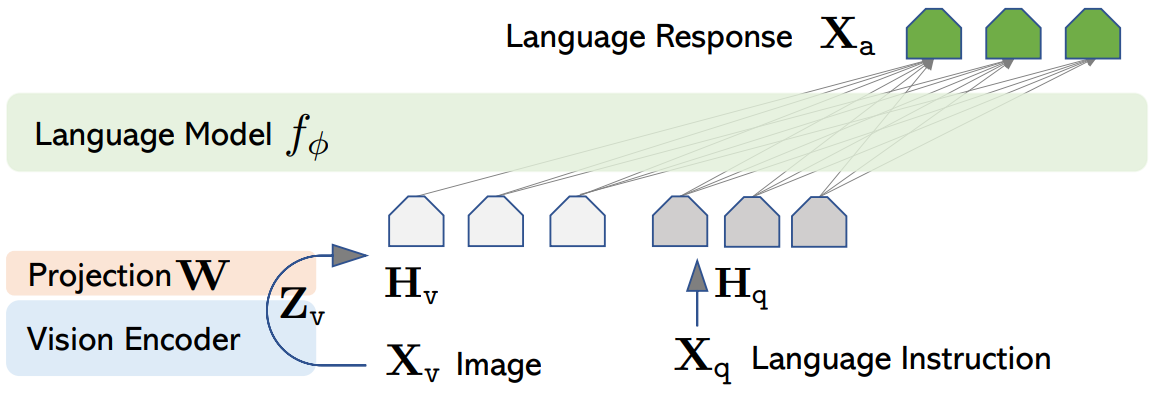

In [ ]:
print("\n[LLaVA] Loading model ...")

try:
    from transformers import AutoProcessor, LlavaForConditionalGeneration
    import torch

    device = "cuda" if torch.cuda.is_available() else "cpu"
    torch_dtype = torch.float16 if device == "cuda" else torch.float32

    model_id = "llava-hf/llava-1.5-7b-hf"

    processor = AutoProcessor.from_pretrained(model_id)
    model = LlavaForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch_dtype,
        low_cpu_mem_usage=True,
        device_map="auto" if device == "cuda" else None,
    )

    if device == "cpu":
        model = model.float()

    question = "What is the animal doing in this image?"
    prompt = f"USER: <image>\n{question}\nASSISTANT:"

    inputs = processor(
        text=prompt,
        images=image,
        return_tensors="pt"
    ).to(model.device)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=50,
            do_sample=False,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id
        )

    answer = processor.decode(output[0], skip_special_tokens=True)
    # Убираем дубли исходного prompt'а
    if "ASSISTANT:" in answer:
        answer = answer.split("ASSISTANT:", 1)[-1].strip()

    print("Q:", question)
    print("A:", answer)

except Exception as e:
    print(f"[LLaVA] Error: {e}")


[LLaVA] Loading model ...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Q: What is the animal doing in this image?
A: The animal, a small brown dog, is sitting in the grass and smiling.
